<a href="https://colab.research.google.com/github/manojgupta3051994/Travel_Claim_Prediction/blob/master/Final_GreyAtom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pylab
!pip install imbalanced-learn
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn import model_selection, preprocessing
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [ ]:
# Importing File

train = pd.read_csv('train.csv')

In [ ]:
# Viewing the dataset

train.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [ ]:
# Describing dataset

train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,52310,NaN,NaN,NaN,6005.75,2306.45,2000,4015,6002,8004,10000
Agency,52310,16,EPX,26218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agency Type,52310,2,Travel Agency,34996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distribution Channel,52310,2,Online,51419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product Name,52310,25,Cancellation Plan,13254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,52310,NaN,NaN,NaN,58.2561,109.139,-2,10,24,57,4881
Destination,52310,97,SINGAPORE,14242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Net Sales,52310,NaN,NaN,NaN,48.5547,60.1986,-389,19.8,29.5,55,682
Commision (in value),52310,NaN,NaN,NaN,12.22,22.8476,0,0,0,13.38,262.76
Age,52310,NaN,NaN,NaN,39.5557,13.7625,0,33,36,43,118


In [ ]:
# Checking Info

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    52310 non-null  int64  
 1   Agency                52310 non-null  object 
 2   Agency Type           52310 non-null  object 
 3   Distribution Channel  52310 non-null  object 
 4   Product Name          52310 non-null  object 
 5   Duration              52310 non-null  int64  
 6   Destination           52310 non-null  object 
 7   Net Sales             52310 non-null  float64
 8   Commision (in value)  52310 non-null  float64
 9   Age                   52310 non-null  int64  
 10  Claim                 52310 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


In [ ]:
# Checking for null values

train.isnull().sum()

ID                      0
Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64

**Based on details displayed in Described method, Replacing Duration with values less than 0 or negative with mean of Duration**

In [ ]:
train.loc[train['Duration']<0,'Duration']=58

**Replacing Commission value as 0 for Net Sales 0 or less than 0**

In [ ]:
train.loc[train['Net Sales'] <= 0.0, 'Commision (in value)'] = 0

In [ ]:
train.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


0    83.330147
1    16.669853
Name: Claim, dtype: float64


0    43590
1     8720
Name: Claim, dtype: int64

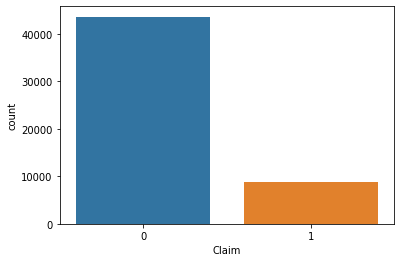

In [ ]:
# Checking for data being Imbalanced

sns.countplot(x = 'Claim', data= train)

print (train['Claim'].value_counts()/len(train)*100)

train['Claim'].value_counts()

**From above plot we can define that data is imbalanced as the number of Claim Acceptance is way low that compared to Claim Rejection. Ratio of Claim Rejection to Acceptance is 5:1**

In [ ]:
# Segregating Data as per datatypes

num_df = train.drop(['Claim','ID'],axis=1).select_dtypes('number')
cat_df = train.select_dtypes('O')

**Operations on Categorical Data - cat_df**

In [ ]:
# Replacing values with 0 and 1 for Agency and Distribution Channel

cat_df.replace(to_replace=['Airlines','Travel Agency'],value=[1,0],inplace=True)
cat_df.replace(to_replace=['Online','Offline'],value=[1,0],inplace=True)
cat_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,EPX,0,1,Cancellation Plan,PHILIPPINES
1,EPX,0,1,Cancellation Plan,MALAYSIA
2,CWT,0,1,Rental Vehicle Excess Insurance,THAILAND
3,EPX,0,1,2 way Comprehensive Plan,HONG KONG
4,EPX,0,1,2 way Comprehensive Plan,MALAYSIA


In [ ]:
# Applying One Hot encoding via get_dummies method for Destination, Agency, Product Name columns

dum_df = pd.get_dummies(cat_df,columns=['Destination','Agency','Product Name'],prefix=['Destination_Is','Agency_Is','Product Name_Is'],drop_first=True)
dum_df.head()

,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,Destination_Is_ICELAND,Destination_Is_INDIA,Destination_Is_INDONESIA,Destination_Is_IRELAND,...,Destination_Is_ZAMBIA,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Visualizing Insights**

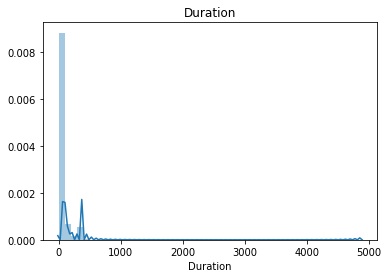

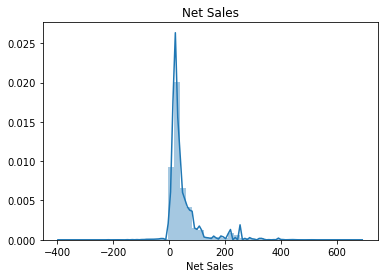

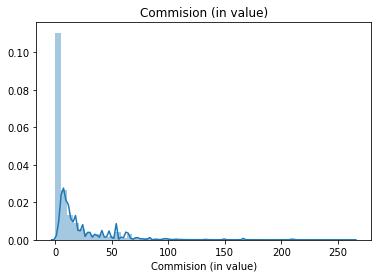

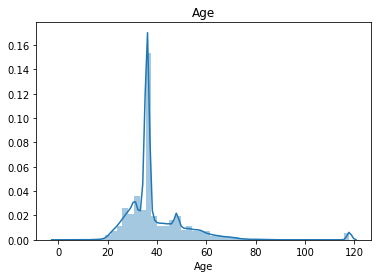

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting Distribution plot for numerical data

for i in num_df.columns:
  plt.title(i)
  sns.distplot(num_df[i])
  plt.show()
  plt.tight_layout()

**From above plot we can see that Duration, Net Sales & Commission in value columns are right skewed. Age is randomly distributed**

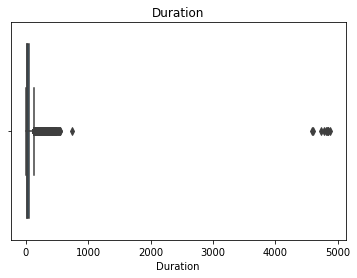

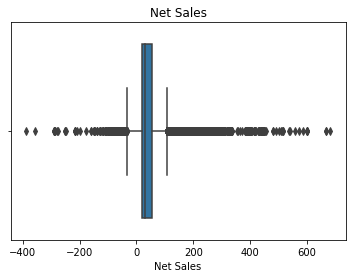

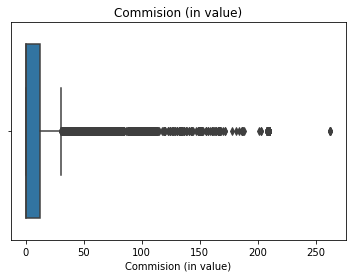

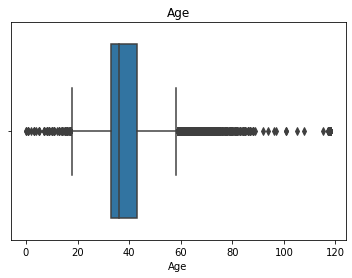

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting Box plot for numerical data

for i in num_df.columns:
  plt.title(i)
  sns.boxplot(num_df[i])
  plt.show()
  plt.tight_layout()

In [ ]:
# Function to plot histogram and QQ plot for dataframe numerical columns

def plot_data(df):
  for i in df.columns:
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[i].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[i],dist='norm',plot=pylab)

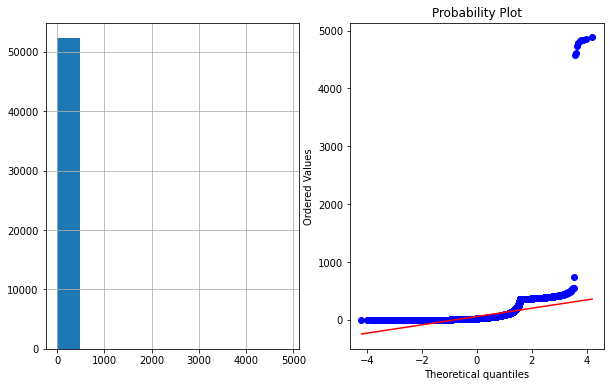

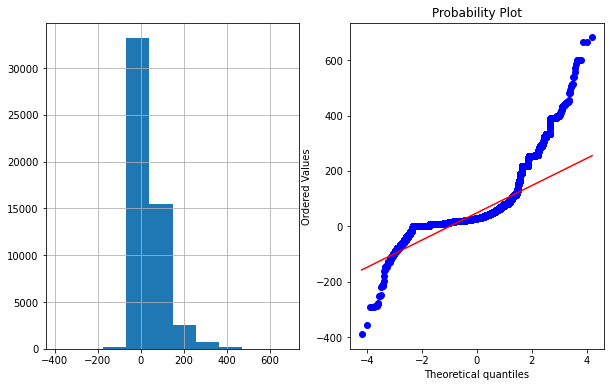

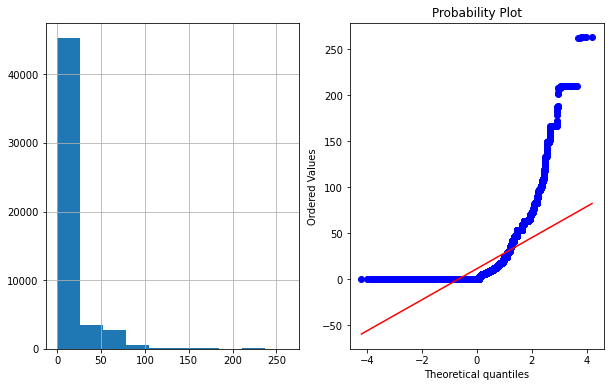

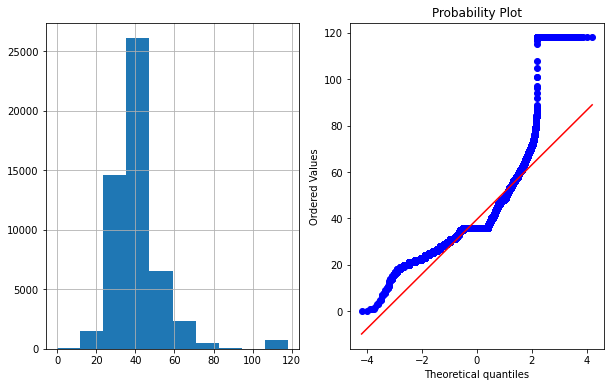

In [ ]:
plot_data(num_df)

<Figure size 720x576 with 0 Axes>

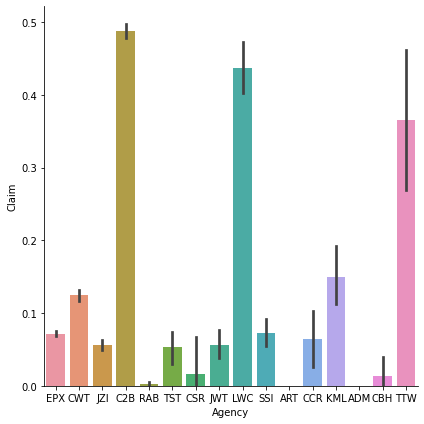

In [ ]:
# Plotting for few categorical data wrt Claim
plt.figure(figsize=(10,8))
sns.catplot(x = 'Agency', y='Claim' , data=train, kind='bar',height=6)
plt.show()


**Claim acceptance ratio with respect to Agency**. **Agencies - C2B, LWC, TTW are having highest claim acceptance numbers**

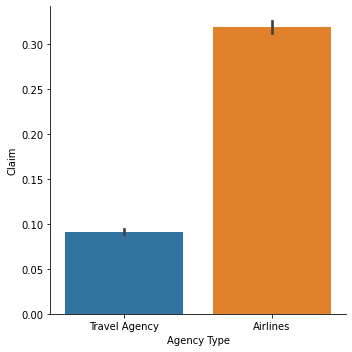

In [ ]:
sns.catplot(x = 'Agency Type', y='Claim' , data=train, kind='bar')

**Claim acceptance ratio with respect to Agency Type**. **Agency Type - Airlines concedes more number of Claim as compared to Travel Agency**

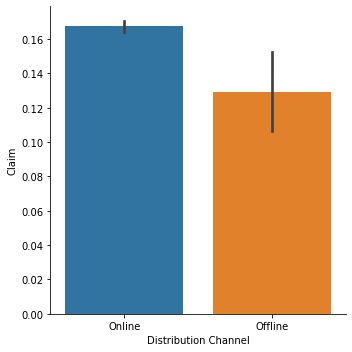

In [ ]:
sns.catplot(x = 'Distribution Channel', y='Claim' , data=train, kind='bar')

**Claim acceptance ratio with respect to Distribution Channel**.

**Outlier Check**

In [ ]:
# Since Age in normally distributed hence calculating the boundaries upto 3+ and 3- std to the mean

upper_boundary = num_df['Age'].mean()+3*num_df['Age'].std()
lower_boundary = num_df['Age'].mean()-3*num_df['Age'].std()
print(upper_boundary), print (lower_boundary), print(num_df['Age'].mean())

80.84314496274234
-1.731693997343747
39.555725482699295


(None, None, None)

In [ ]:
# For Skewed columns we need to find IQR and calculate the boundaries

IQR = num_df['Duration'].quantile(0.75)-num_df['Duration'].quantile(0.25)

lower_bridge = num_df['Duration'].quantile(0.25)-(IQR*1.5)
upper_bridge = num_df['Duration'].quantile(0.75)+(IQR*1.5)

print (lower_bridge), print(upper_bridge)
print('Extreme Outliers')
lb = num_df['Duration'].quantile(0.25)-(IQR*3)
ub = num_df['Duration'].quantile(0.75)+(IQR*3)

print (lb) , print (ub)

-60.5
127.5
Extreme Outliers
-131.0
198.0


(None, None)

In [ ]:
# For Skewed columns we need to find IQR and calculate the boundaries

IQR = num_df['Net Sales'].quantile(0.75)-num_df['Net Sales'].quantile(0.25)

lower_bridge = num_df['Net Sales'].quantile(0.25)-(IQR*1.5)
upper_bridge = num_df['Net Sales'].quantile(0.75)+(IQR*1.5)

print (lower_bridge), print(upper_bridge)

print('Extreme Outliers')
lb = num_df['Net Sales'].quantile(0.25)-(IQR*3)
ub = num_df['Net Sales'].quantile(0.75)+(IQR*3)

print (lb) , print (ub)

-33.0
107.80000000000001
Extreme Outliers
-85.80000000000001
160.60000000000002


(None, None)

In [ ]:
# For Skewed columns we need to find IQR and calculate the boundaries

IQR = num_df['Commision (in value)'].quantile(0.75)-num_df['Commision (in value)'].quantile(0.25)

lower_bridge = num_df['Commision (in value)'].quantile(0.25)-(IQR*1.5)
upper_bridge = num_df['Commision (in value)'].quantile(0.75)+(IQR*1.5)

print (lower_bridge), print(upper_bridge)
print('Extreme Outliers')
lb = num_df['Commision (in value)'].quantile(0.25)-(IQR*3)
ub = num_df['Commision (in value)'].quantile(0.75)+(IQR*3)

print (lb) , print (ub)

-18.375
30.625
Extreme Outliers
-36.75
49.0


(None, None)

**Concatenating num_df and cat_df**

In [ ]:
train_new = pd.concat([num_df,dum_df],axis=1)
train_new.head()

,Duration,Net Sales,Commision (in value),Age,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,...,Destination_Is_ZAMBIA,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan
0,61,12.0,0.00,41,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,17.0,0.00,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,19.8,11.88,47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,15,27.0,0.00,48,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,37.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Adding the Claim column to final table

train_new['Claim'] = train['Claim']
train_new.head()

,Duration,Net Sales,Commision (in value),Age,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,...,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan,Claim
0,61,12.0,0.00,41,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,17.0,0.00,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,19.8,11.88,47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,15,27.0,0.00,48,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,37.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Feature Selection/Feature Iportance**

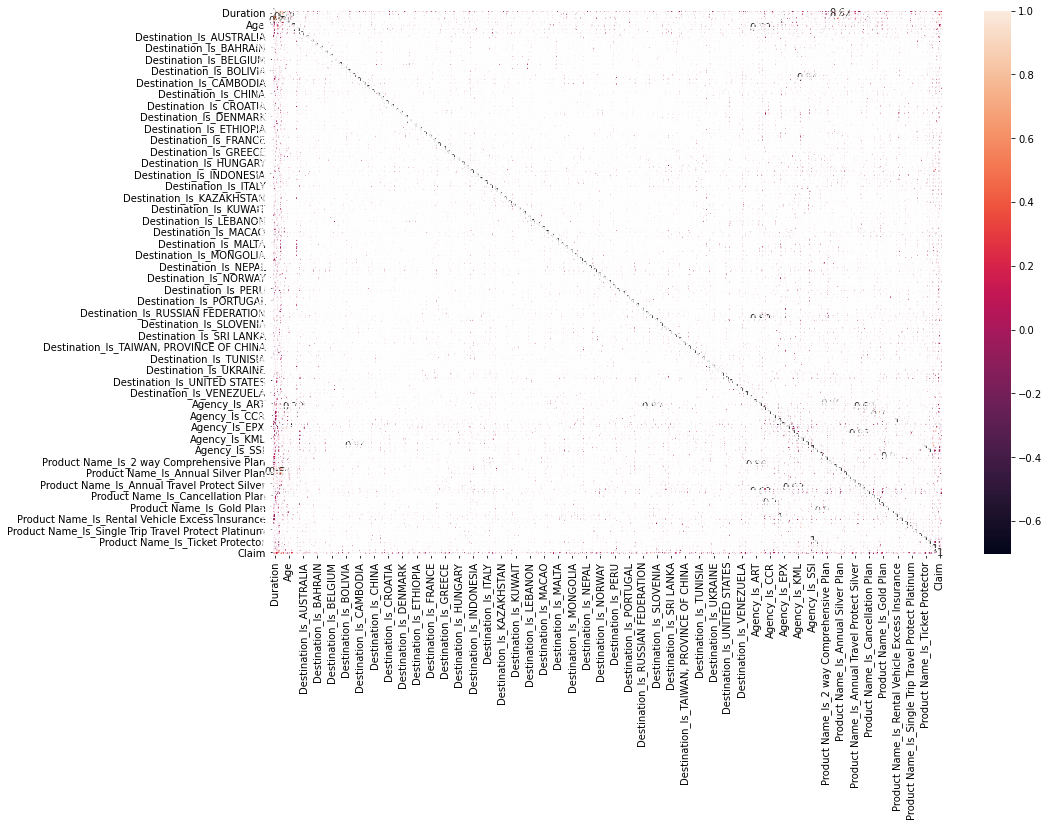

<Figure size 432x288 with 0 Axes>

In [ ]:
# Finding correlation using Heatmap

plt.figure(figsize=(15,10))
corr = train_new.corr()
top_features = corr.index 
sns.heatmap(train_new[top_features].corr(), annot=True)
plt.show()
plt.tight_layout()

In [ ]:
#Correlation with output variable
cor_target = abs(corr["Claim"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

Duration                              0.201567
Net Sales                             0.326799
Commision (in value)                  0.277622
Agency Type                           0.287299
Destination_Is_MALAYSIA               0.104974
Destination_Is_SINGAPORE              0.337842
Agency_Is_C2B                         0.434577
Agency_Is_EPX                         0.255486
Product Name_Is_Annual Silver Plan    0.262484
Product Name_Is_Bronze Plan           0.220613
Product Name_Is_Cancellation Plan     0.218688
Product Name_Is_Silver Plan           0.204544
Claim                                 1.000000
Name: Claim, dtype: float64

**From above we can see features that impact Target Variable Claim**

In [ ]:
# Splitting Dataset into X(Features) and y(Target)

X = train_new.iloc[:,:-1]
y = train_new.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=True)

In [ ]:
# Feature Importance using Extra Trees Classifer

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
print(model.feature_importances_)

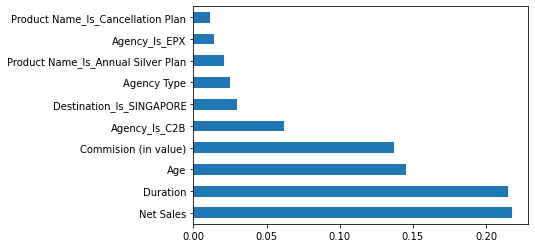

In [ ]:
feat = pd.Series(model.feature_importances_,index=X.columns)
feat.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
# Feature importance using mutual_info_classif

from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X,y)
mutual_data = pd.Series(mutual_info,index=X.columns)
mutual_data.sort_values(ascending=False)

Net Sales                                   0.264765
Commision (in value)                        0.179196
Agency_Is_C2B                               0.076991
Destination_Is_SINGAPORE                    0.049254
Duration                                    0.043593
                                              ...   
Destination_Is_GEORGIA                      0.000000
Destination_Is_UNITED ARAB EMIRATES         0.000000
Product Name_Is_Child Comprehensive Plan    0.000000
Destination_Is_FIJI                         0.000000
Destination_Is_PAKISTAN                     0.000000
Length: 141, dtype: float64

**Since target variable is imbalanced and for resolving it we will be using SMOTETomek**

In [ ]:
# Implementing SMOTETomek

smt = SMOTETomek(ratio='auto')
X_st,y_st = smt.fit_sample(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Test Models and evaluation metric


# Spot Check Algorithms
Mymodels = []
#Mymodels.append(('LogReg', LogisticRegression(solver='lbfgs')))
Mymodels.append(('RandomForest', RandomForestClassifier()))
#Mymodels.append(('SGDclassifier', SGDClassifier()))
#Mymodels.append(('KNearestNeighbors', KNeighborsClassifier()))
#Mymodels.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
#Mymodels.append(('GaussianNB', GaussianNB()))
#Mymodels.append(('SVM', SVC()))
#Mymodels.append(('CatBoost',CatBoostClassifier()))

# Evaluate each model in turn

for name, model in Mymodels:
    skf = StratifiedKFold(n_splits=10,random_state=None)
    skf.get_n_splits(X_st,y_st)
    for train_index, test_index in skf.split(X_st,y_st):
      print('Train:', train_index, 'Test',test.index)
      X1_train,X1_test = X_st[train_index],X_st[test_index]
      y1_train,y1_test = y_st[train_index],y_st[test_index]
      model.fit(X1_train,y1_train)
      y_pred = model.predict(X1_test)
      
      

Train: [ 5178  5179  5180 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 86507 86508 86509] Test RangeIndex(start=0, stop=22421, step=1)
Train: [    0     1     2 ... 82181 82182 82183] Test RangeIndex(start=0, stop=22421, step=1)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score
print (precision_score(y1_test,y_pred))
print (confusion_matrix(y1_test,y_pred))

0.967437682461262
[[4180  145]
 [  18 4308]]


In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplt

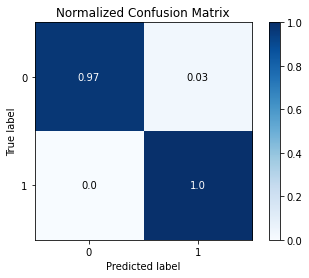

In [ ]:
skplt.metrics.plot_confusion_matrix(y1_test,y_pred,normalize=True)

In [ ]:
prob = model.predict_proba(X1_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


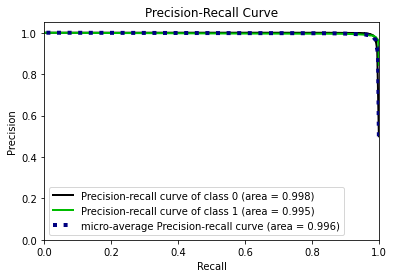

In [ ]:
skplt.metrics.plot_precision_recall_curve(y1_test, prob)

**Test Data**

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,17631,EPX,Travel Agency,Online,Cancellation Plan,192,HONG KONG,18.0,0.00,36
1,15064,EPX,Travel Agency,Online,1 way Comprehensive Plan,2,SINGAPORE,20.0,0.00,36
2,14139,C2B,Airlines,Online,Bronze Plan,13,SINGAPORE,13.5,3.38,24
3,19754,EPX,Travel Agency,Online,2 way Comprehensive Plan,133,"TAIWAN, PROVINCE OF CHINA",41.0,0.00,36
4,16439,C2B,Airlines,Online,Silver Plan,2,SINGAPORE,30.0,7.50,32


In [ ]:
Test_ID = test['ID']

In [ ]:
test.drop('ID',1,inplace=True)

In [ ]:
test.loc[test['Duration']<0,'Duration']=58

In [ ]:
test.loc[test['Net Sales'] <= 0.0, 'Commision (in value)'] = 0

In [ ]:
test_num_df = test.select_dtypes('number')
test_cat_df = test.select_dtypes('O')

In [ ]:
# Replacing values with 0 and 1 for Agency and Distribution Channel

test_cat_df.replace(to_replace=['Airlines','Travel Agency'],value=[1,0],inplace=True)
test_cat_df.replace(to_replace=['Online','Offline'],value=[1,0],inplace=True)
test_cat_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,EPX,0,1,Cancellation Plan,HONG KONG
1,EPX,0,1,1 way Comprehensive Plan,SINGAPORE
2,C2B,1,1,Bronze Plan,SINGAPORE
3,EPX,0,1,2 way Comprehensive Plan,"TAIWAN, PROVINCE OF CHINA"
4,C2B,1,1,Silver Plan,SINGAPORE


In [ ]:
# Applying One Hot encoding via get_dummies method for Destination, Agency, Product Name columns

test_dum_df = pd.get_dummies(test_cat_df,columns=['Destination','Agency','Product Name'],prefix=['Destination_Is','Agency_Is','Product Name_Is'],drop_first=True)
test_dum_df.head()

,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,Destination_Is_ICELAND,Destination_Is_INDIA,Destination_Is_INDONESIA,Destination_Is_IRELAND,...,Destination_Is_ZAMBIA,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
test_new = pd.concat([test_num_df,test_dum_df],axis=1)
test_new.head()

,Duration,Net Sales,Commision (in value),Age,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,...,Destination_Is_ZAMBIA,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan
0,192,18.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,20.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,13.5,3.38,24,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,133,41.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,30.0,7.50,32,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
Final_Test = test_new.iloc[:].values

In [ ]:
Final_Test

array([[192.  ,  18.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  2.  ,  20.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [ 13.  ,  13.5 ,   3.38, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  5.  ,  20.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [ 15.  ,  10.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [ 25.  ,  20.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [ ]:
test_new['Results'] = model.predict(Final_Test)

In [ ]:
test_new

,Duration,Net Sales,Commision (in value),Age,Agency Type,Distribution Channel,Destination_Is_AUSTRALIA,Destination_Is_AUSTRIA,Destination_Is_AZERBAIJAN,Destination_Is_BAHRAIN,Destination_Is_BANGLADESH,Destination_Is_BELARUS,Destination_Is_BELGIUM,Destination_Is_BERMUDA,Destination_Is_BHUTAN,Destination_Is_BOLIVIA,Destination_Is_BRAZIL,Destination_Is_BRUNEI DARUSSALAM,Destination_Is_CAMBODIA,Destination_Is_CANADA,Destination_Is_CHILE,Destination_Is_CHINA,Destination_Is_COLOMBIA,Destination_Is_COSTA RICA,Destination_Is_CROATIA,Destination_Is_CYPRUS,Destination_Is_CZECH REPUBLIC,Destination_Is_DENMARK,Destination_Is_EGYPT,Destination_Is_ESTONIA,Destination_Is_ETHIOPIA,Destination_Is_FIJI,Destination_Is_FINLAND,Destination_Is_FRANCE,Destination_Is_GEORGIA,Destination_Is_GERMANY,Destination_Is_GREECE,Destination_Is_GUAM,Destination_Is_HONG KONG,Destination_Is_HUNGARY,...,Agency_Is_ART,Agency_Is_C2B,Agency_Is_CBH,Agency_Is_CCR,Agency_Is_CSR,Agency_Is_CWT,Agency_Is_EPX,Agency_Is_JWT,Agency_Is_JZI,Agency_Is_KML,Agency_Is_LWC,Agency_Is_RAB,Agency_Is_SSI,Agency_Is_TST,Agency_Is_TTW,Product Name_Is_2 way Comprehensive Plan,Product Name_Is_24 Protect,Product Name_Is_Annual Gold Plan,Product Name_Is_Annual Silver Plan,Product Name_Is_Annual Travel Protect Gold,Product Name_Is_Annual Travel Protect Platinum,Product Name_Is_Annual Travel Protect Silver,Product Name_Is_Basic Plan,Product Name_Is_Bronze Plan,Product Name_Is_Cancellation Plan,Product Name_Is_Child Comprehensive Plan,Product Name_Is_Comprehensive Plan,Product Name_Is_Gold Plan,Product Name_Is_Individual Comprehensive Plan,Product Name_Is_Premier Plan,Product Name_Is_Rental Vehicle Excess Insurance,Product Name_Is_Silver Plan,Product Name_Is_Single Trip Travel Protect Gold,Product Name_Is_Single Trip Travel Protect Platinum,Product Name_Is_Single Trip Travel Protect Silver,Product Name_Is_Spouse or Parents Comprehensive Plan,Product Name_Is_Ticket Protector,Product Name_Is_Travel Cruise Protect,Product Name_Is_Value Plan,Results
0,192,18.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,20.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,13.5,3.38,24,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,133,41.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,30.0,7.50,32,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22416,10,0.0,0.00,27,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
22417,32,33.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22418,5,20.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22419,15,10.0,0.00,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Submissions = pd.concat([Test_ID,test_new['Results']],axis=1)

In [ ]:
Submissions

,ID,Results
0,17631,0
1,15064,0
2,14139,0
3,19754,0
4,16439,0
...,...,...
22416,13227,0
22417,12767,1
22418,13638,0
22419,14859,0


In [ ]:
Submissions.to_csv('Travel_Insurance_Claim_Prediction_Submission.csv',index=False)